In [1]:
%cd /content/drive/"My Drive"/stock

/content/drive/My Drive/stock


In [2]:
!pip3 install alpha_vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=df97d87d3eb24f8b850e6b593f20fa27d57fa386f1f6bd060623f1186d579079
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


In [0]:
from alpha_vantage.timeseries import TimeSeries

def save_dataset(symbol):
  api_key = #YOUR API KEY from alpha advantage

  ts = TimeSeries(key=api_key, output_format='pandas')
  data, _ = ts.get_daily(symbol, outputsize= 'full')

  data.to_csv(symbol + "_daily.csv")

In [0]:
symbol = 'GE'

save_dataset(symbol)

In [14]:
import pandas as pd 
import numpy as np

data = pd.read_csv(symbol + "_daily.csv")
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

data = data.sort_values('Date')
print(data.shape)
data.head()

(5033, 6)


,Date,Open,High,Low,Close,Volume
5032,2000-03-13,129.00,130.50,127.62,129.44,6420300.0
5031,2000-03-14,129.63,129.75,126.81,127.00,6356800.0
5030,2000-03-15,126.87,134.69,126.25,133.56,8637000.0
5029,2000-03-16,133.69,139.44,133.50,139.00,10001600.0
5028,2000-03-17,138.13,141.44,137.19,139.88,10621000.0


In [15]:
data.tail()

,Date,Open,High,Low,Close,Volume
4,2020-03-09,8.33,8.665,8.11,8.21,122072605.0
3,2020-03-10,8.78,8.850,8.16,8.85,98849765.0
2,2020-03-11,8.62,8.660,8.16,8.21,101330062.0
1,2020-03-12,7.23,7.780,6.83,7.23,156996660.0
0,2020-03-13,7.80,8.040,7.19,7.85,110060018.0


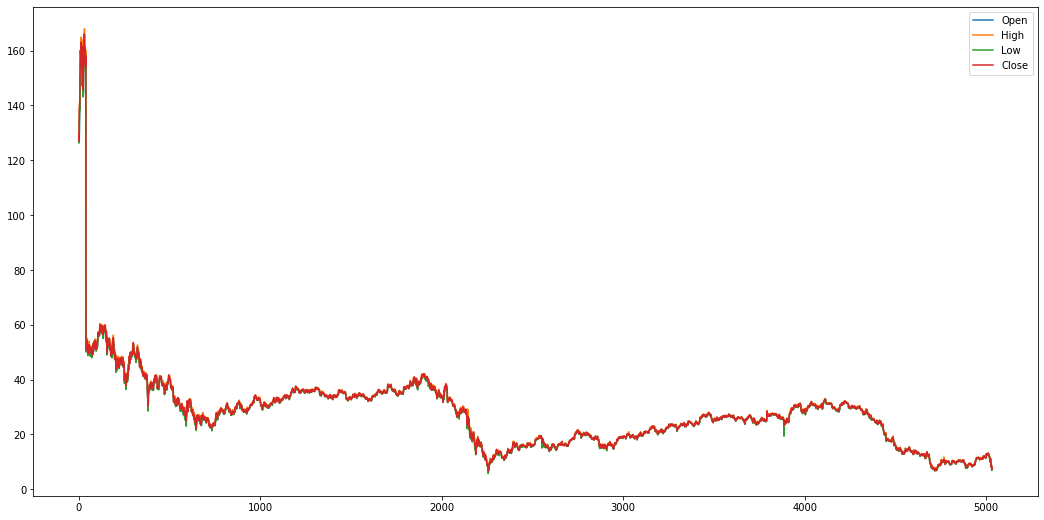

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 9))
plt.plot(range(0, data.shape[0]), data['Open'])
plt.plot(range(0, data.shape[0]), data['High'])
plt.plot(range(0, data.shape[0]), data['Low'])
plt.plot(range(0, data.shape[0]), data['Close'])


plt.legend(['Open', 'High', 'Low', 'Close'])

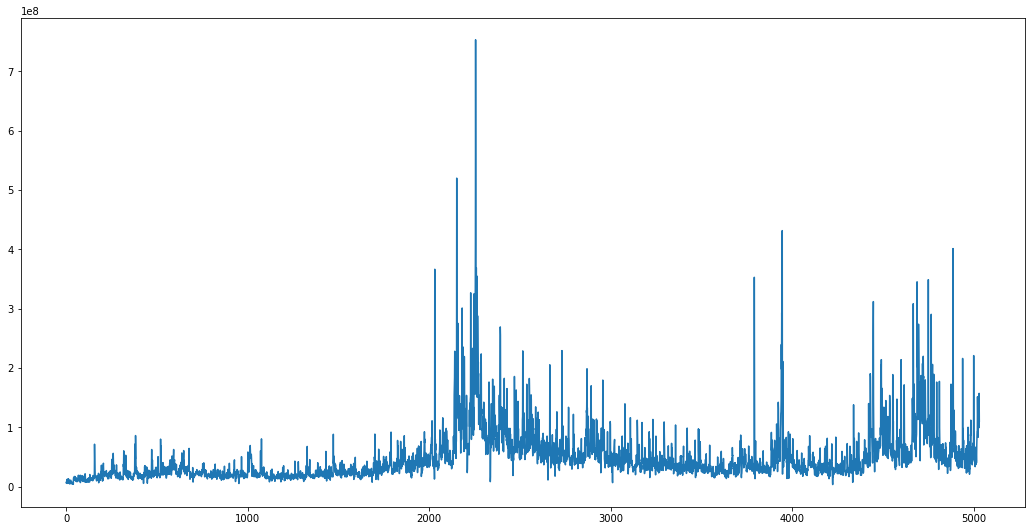

In [21]:
plt.figure(figsize=(18, 9))
plt.plot(range(0, data.shape[0]), data['Volume'])

In [23]:
print("Check for null values", data.isna().sum())


Check for null values Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [25]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print(df_train.shape, df_test.shape)

(4026, 6) (1007, 6)


In [0]:
train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

x = df_train.loc[:, train_cols].values
minmaxscaler = MinMaxScaler()
x_train = minmaxscaler.fit_transform(x)
x_test = minmaxscaler.transform(df_test.loc[:,train_cols].values)

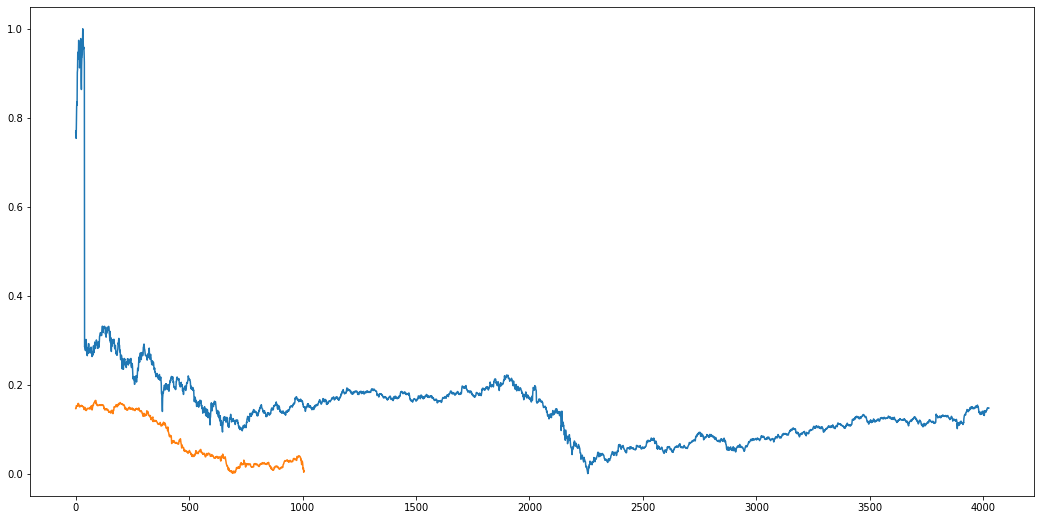

In [27]:
plt.figure(figsize=(18, 9))
plt.plot(x_train[:, 0])
plt.plot(x_test[:, 0])


In [0]:
TIME_STEP = 100
def build_data(mat, Yindex):
  x = np.zeros((mat.shape[0] - TIME_STEP, TIME_STEP, mat.shape[1]))
  y = np.zeros((mat.shape[0] - TIME_STEP, ))

  for i in range(mat.shape[0] - TIME_STEP):
    x[i] = mat[i: i + TIME_STEP]
    y[i] = mat[TIME_STEP + i, Yindex]

  return x, y

In [30]:
x_t, y_t = build_data(x_train, 3)

x_tmp, y_tmp = build_data(x_test, 3)

x_val, x_testt = np.array_split(x_tmp ,2)
y_val, y_testt = np.array_split(y_tmp ,2)

print(y_val.shape, y_testt.shape)

(454,) (453,)


In [32]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(256, input_shape=( TIME_STEP, x_t.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer=RMSprop())




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [33]:
import os 

mcp = ModelCheckpoint(os.path.join(symbol + "_BM.h5"), monitor='val_loss',
                      save_best_only=True, save_weights_only=False, mode='min', period=1)

history = model.fit(x_t, y_t, epochs= 300, batch_size=512,
                    shuffle=False, validation_data=(x_val, y_val), callbacks=[mcp])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3926 samples, validate on 454 samples
Epoch 1/300





3926/3926 [==============================] - 13s 3ms/step - loss: 0.0271 - val_loss: 0.0047
Epoch 2/300
3926/3926 [==============================] - 3s 742us/step - loss: 0.0155 - val_loss: 0.0016
Epoch 3/300
3926/3926 [==============================] - 3s 745us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 4/300
3926/3926 [==============================] - 3s 730us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 5/300
3926/3926 [==============================] - 3s 742us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 6/300
3926/3926 [==============================] - 3s 730us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 7/300
3926/3926 [==============================] - 3s 752us/step - loss: 0.0046 - val_loss: 0.0015
Epoch 8/300
3926/3926 [==============================] - 3s 740us/step - loss: 0.0047 - val_loss: 0.0016
Epoch 9/300


Text(0, 0.5, 'Loss')

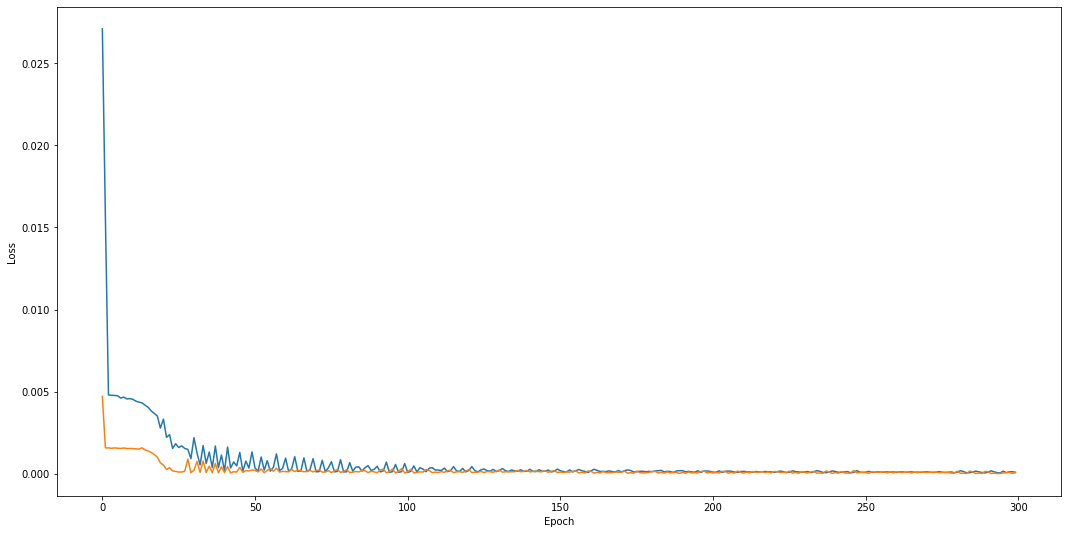

In [34]:
plt.figure(figsize=(18, 9))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Loss', 'Val_loss'])


In [35]:
from sklearn.metrics import mean_squared_error

saved_model = load_model(os.path.join(symbol + "_BM.h5"))

y_preds = saved_model.predict(x_testt, batch_size=512)
y_preds = y_preds.flatten()

error = mean_squared_error(y_testt, y_preds)
print("Error = ", error)


print(y_preds[:15])
print(y_testt[:15])

y_test_org = (y_testt * minmaxscaler.data_range_[3]) + minmaxscaler.data_min_[3]
y_preds_org = (y_preds * minmaxscaler.data_range_[3]) + minmaxscaler.data_min_[3]


print(y_preds_org[:15])
print(y_test_org[:15])




Error =  0.0003101800515815474
[0.05764937 0.05820042 0.05704945 0.05663595 0.05587384 0.05539316
 0.05439946 0.0540477  0.05384275 0.05335039 0.05359879 0.05382559
 0.05406857 0.05433869 0.0537807 ]
[0.05001883 0.04719468 0.04713192 0.04656709 0.04669261 0.04424501
 0.04480984 0.0438057  0.04468432 0.04562571 0.0459395  0.0459395
 0.04537467 0.0438057  0.0416719 ]
[15.845851 15.933655 15.750259 15.684371 15.562938 15.486345 15.32801
 15.271961 15.239304 15.160851 15.200431 15.236568 15.275285 15.318327
 15.229417]
[14.63 14.18 14.17 14.08 14.1  13.71 13.8  13.64 13.78 13.93 13.98 13.98
 13.89 13.64 13.3 ]


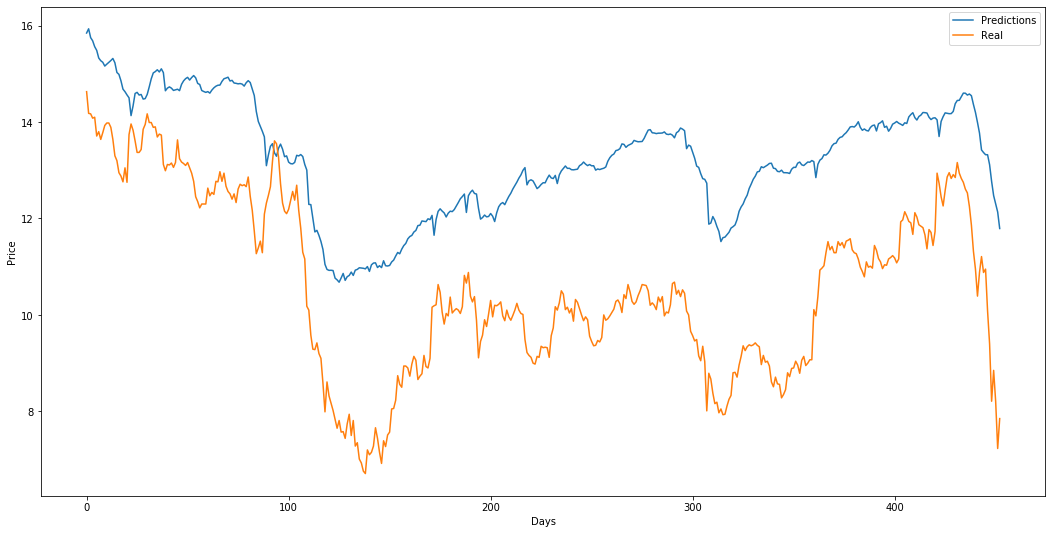

In [36]:
plt.figure(figsize=(18, 9))
plt.plot(y_preds_org)
plt.plot(y_test_org)
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(['Predictions', 'Real'])